In [99]:
import pandas as pd
from sklearn import preprocessing
import argparse
import numpy as np
import scipy
import csv
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from time import time
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.grid_search import ParameterGrid
import pylab as pl
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import ParameterGrid
from scipy import interp
from sklearn.cross_validation import StratifiedKFold
import math
import sys
import itertools
%matplotlib inline

In [100]:
INPUT_PRICE = 25
INPUT_COST = 10
if INPUT_PRICE - INPUT_COST <= 0:
    print("Invalid input")

               age      campaign         pdays      previous  emp.var.rate  \
count  41188.00000  41188.000000  41188.000000  41188.000000  41188.000000   
mean      40.02406      2.567593    962.475454      0.172963      0.081886   
std       10.42125      2.770014    186.910907      0.494901      1.570960   
min       17.00000      1.000000      0.000000      0.000000     -3.400000   
25%       32.00000      1.000000    999.000000      0.000000     -1.800000   
50%       38.00000      2.000000    999.000000      0.000000      1.100000   
75%       47.00000      3.000000    999.000000      0.000000      1.400000   
max       98.00000     56.000000    999.000000      7.000000      1.400000   

       cons.price.idx  cons.conf.idx     euribor3m   nr.employed  
count    41188.000000   41188.000000  41188.000000  41188.000000  
mean        93.575664     -40.502600      3.621291   5167.035911  
std          0.578840       4.628198      1.734447     72.251528  
min         92.201000     -50

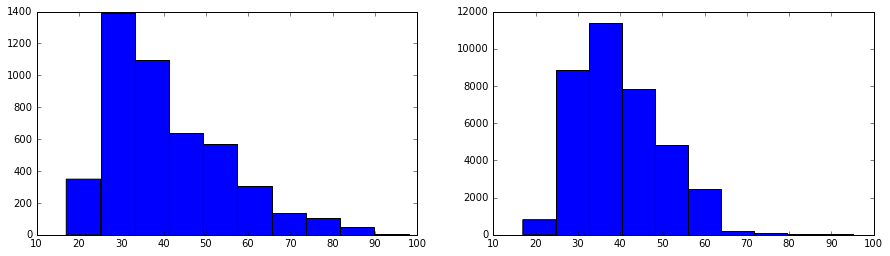

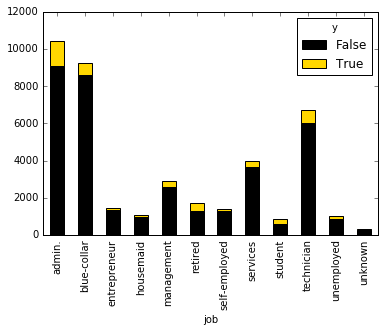

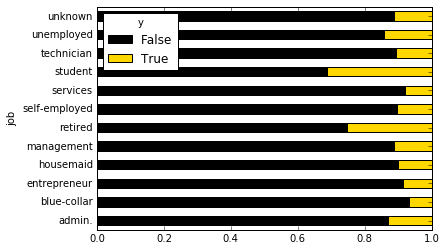

In [101]:
data = pd.read_csv('bank-additional-full.csv', delimiter=';')

# remove feature 'duration'
data = data.drop('duration', 1)

fig, axs = plt.subplots(ncols=2, figsize=(15,4))
data[data.y == 'yes'].age.hist(grid=False, ax=axs[0])
data[data.y == 'no'].age.hist(grid=False, ax=axs[1])

print(data.describe())

# Label Encoding. Encode y (target) first, then we can visualize the data
lab = preprocessing.LabelEncoder()
data.y = lab.fit_transform(data.y)

# visualize the data
yes_counts = pd.crosstab([data.job], data.y.astype(bool))
yes_counts.plot(kind='bar', stacked=True, color=['black', 'gold'], grid=False)

yes_counts.div(yes_counts.sum(1).astype(float), axis=0).plot(kind='barh', stacked=True, color=['black','gold'])



In [87]:
#print(data.head())
numeric_features = ['age', 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx', 
                    'cons.conf.idx', 'euribor3m', 'nr.employed'] # numeric features
data_for_scale = data.values # an array of all values, 41188 X 21
#data.axes

array([[56, 'housemaid', 'married', ..., 4.857, 5191.0, 0],
       [57, 'services', 'married', ..., 4.857, 5191.0, 0],
       [37, 'services', 'married', ..., 4.857, 5191.0, 0],
       ..., 
       [56, 'retired', 'married', ..., 1.028, 4963.6, 0],
       [44, 'technician', 'married', ..., 1.028, 4963.6, 1],
       [74, 'retired', 'married', ..., 1.028, 4963.6, 0]], dtype=object)

In [82]:
def scale_numerical(data):
    k=0 # column index
    for i in data:  # for every column
        if i in numeric_features:
            min_i = min(data[i])
            max_i = max(data[i]) 
            print(i,min_i,max_i)
            for j in range(len(data)):
                #print(j)
                # x after scale, = (x-min[i])/(max[i]-min[i])   
                temp = data[i][j]*1.0
                data_for_scale[j,k] = (temp-min_i)/(max_i-min_i) 
        k += 1                 
    return data_for_scale   

In [83]:
scaled_data_values = scale_numerical(data) # an array with numerical values scaled
features = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
        'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous',
        'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
        'euribor3m', 'nr.employed', 'y']
scaled_data = pd.DataFrame(scaled_data_values,columns = features) # transfer array to DataFrame
scaled_data.head()


age 17 98
campaign 1 56
previous 0 7
emp.var.rate -3.4 1.4
cons.price.idx 92.201 94.767
cons.conf.idx -50.8 -26.9
euribor3m 0.634 5.045
nr.employed 4963.6 5228.1


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,0.481481,housemaid,married,basic.4y,no,no,no,telephone,may,mon,0,999,0,nonexistent,0.9375,0.698753,0.60251,0.957379,0.859735,0
1,0.493827,services,married,high.school,unknown,no,no,telephone,may,mon,0,999,0,nonexistent,0.9375,0.698753,0.60251,0.957379,0.859735,0
2,0.246914,services,married,high.school,no,yes,no,telephone,may,mon,0,999,0,nonexistent,0.9375,0.698753,0.60251,0.957379,0.859735,0
3,0.283951,admin.,married,basic.6y,no,no,no,telephone,may,mon,0,999,0,nonexistent,0.9375,0.698753,0.60251,0.957379,0.859735,0
4,0.481481,services,married,high.school,no,no,yes,telephone,may,mon,0,999,0,nonexistent,0.9375,0.698753,0.60251,0.957379,0.859735,0


In [102]:
# Label Encoding
def encoding(data):
    lab = preprocessing.LabelEncoder()
    data.job = lab.fit_transform(data.job)
    data.marital = lab.fit_transform(data.marital)
    data.education = lab.fit_transform(data.education)
    data.default = lab.fit_transform(data.default)
    data.housing = lab.fit_transform(data.housing)
    data.loan = lab.fit_transform(data.loan)
    data.contact = lab.fit_transform(data.contact)
    data.month = lab.fit_transform(data.month)
    data['day_of_week'] = lab.fit_transform(data['day_of_week'])
    data.poutcome = lab.fit_transform(data.poutcome)
    #data.y = lab.fit_transform(data.y)
    return data

In [103]:
data = encoding(data)
# because column 'duration' is deleted, so there are totally 19 featrues and one label.
features = data.as_matrix() # features shape: (41188, 19)
target = features[:, 19] 
features_numeric = features[:, 0:19] # shape: (41188, 19) (index 20 won't be included)

In [104]:
print(features_numeric[0])
# [  5.60000000e+01   3.00000000e+00   1.00000000e+00   0.00000000e+00
#    0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
#    6.00000000e+00   1.00000000e+00   2.61000000e+02   1.00000000e+00
#    9.99000000e+02   0.00000000e+00   1.00000000e+00   1.10000000e+00
#    9.39940000e+01  -3.64000000e+01   4.85700000e+00   5.19100000e+03]

# One-k-scheme encoding
from sklearn.preprocessing import OneHotEncoder
cat_indices = np.array([[1,2,3,4,5,6,7,8,9,14]]) # [1,11,12,13,15,16,17,18,19]  ########need change

enc = OneHotEncoder(categorical_features = cat_indices)
encoded_features1 = enc.fit_transform(features_numeric)
print(enc.n_values_)
# [12  4  8  3  3  3  2 10  5  3]

print(enc.feature_indices_)
# [ 0 12 16 24 27 30 33 35 45 50 53]

print(len(encoded_features1.toarray()[0]))
# 63

print(encoded_features1.toarray()[0]) # print the first row of data (it has rearranged category features in front of all continuous features)
# [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00(housemaid, which is encoded as 3)
#    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
#    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
#    0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
#    1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
#    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
#    1.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
#    0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
#    0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
#    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
#    0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
#    0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
#    0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
#    0.00000000e+00   5.60000000e+01   2.61000000e+02   1.00000000e+00
#    9.99000000e+02   0.00000000e+00   1.10000000e+00   9.39940000e+01
#   -3.64000000e+01   4.85700000e+00   5.19100000e+03]


[  5.60000000e+01   3.00000000e+00   1.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
   6.00000000e+00   1.00000000e+00   1.00000000e+00   9.99000000e+02
   0.00000000e+00   1.00000000e+00   1.10000000e+00   9.39940000e+01
  -3.64000000e+01   4.85700000e+00   5.19100000e+03]


ValueError: X needs to contain only non-negative integers.

In [160]:
# Splitting data
X_train, X_test, Y_train, Y_test = train_test_split(encoded_features1.todense(), target, test_size=0.4, random_state=0)
print(X_train.shape)
print(X_test.shape)

(24712, 63)
(16476, 63)


In [170]:
def run_classifier(classifier_id):    
    classifiers = (None, RandomForestClassifier, SVC, LogisticRegression, DecisionTreeClassifier)

    grid_RF = [{'max_depth': [5, 10, 15], 'criterion': ['entropy', 'gini'], 'n_estimators': [50, 100, 250], 'class_weight': ['balanced']}]
    
    # TODO: do we need to include linear kernel?
    grid_SVC = [{'kernel': ['rbf', 'linear'], 'C': [0.1, 1.0, 100.0], 'gamma': [0.001, 0.1, 10.0], 'class_weight': ['balanced'], 'probability': [True]}]
    
    # TODO: scale every predictor variable with maximum absolute value first, then train the model
    grid_LR = [{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'class_weight': ['balanced']}]

    grid_DT = [{'criterion': ['entropy', 'gini'], 'max_depth': [5, 10, 15]}]

    grids = (None, grid_RF, grid_SVC, grid_LR, grid_DT)
    grid_obj = grids[classifier_id]
    cls_obj = classifiers[classifier_id]

    best_param = None
    best_score = None
    best_model = None
    print ("Performing cross validation using parameter grid...")
    for one_param in ParameterGrid(grid_obj):
        cls = cls_obj(**one_param)

        one_score = cross_val_score(cls, X_train, Y_train, cv=5, scoring='roc_auc')
        mscore = one_score.mean()

#         print ("param=%s, score=%.6f" % (repr(one_param),mscore))

        if ( best_score is None or best_score < mscore): 
            best_param = one_param
            best_score = mscore
            best_model = cls
    
    print ("Best score for Cross Validation: %.6f" % best_score)
    print("Best param: %s" % repr(best_param))

    ### ROC
    classifier_name_list = (None, "Random Forest", "SVM", "Logistic Regression", "Decision Trees")
    best_model.fit(X_train, Y_train)
    
    # len(best_model.feature_importances_) = 63 (there are 63 features after encoding)
#     print("best_model.feature_importances_: %s" % repr(best_model.feature_importances_))
    
    # TODO: Which approach should we use? by min. distance or by cost?
    best_params = get_best_model_params(best_model, X_train, Y_train, classifier_name_list[classifier_id])
    print("(best_fpr, best_tpr, best_threshold, best_fpr_by_cost, best_tpr_by_cost, best_threshold_by_cost) = ")
    print(best_params)
    
    predict_test(best_model, X_test, Y_test, classifier_name_list[classifier_id], best_params)

    
def predict_test(best_model, x_data, y_data, classifier_name, best_params):
    probas_ = best_model.predict_proba(x_data) # len(probas_) = size of testing set
#     print("probas_ = ")
#     print(probas_)    
    
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_data, probas_[:, 1]) # pick prob. of yes(encoded as 1)(corresponds to index 1)
#     print("=============")
#     print("length of fpr = " + str(len(fpr))) # 237
#     print(fpr)
#     print("length of tpr = " + str(len(tpr))) # 237
#     print(tpr)
#     print("length of thresholds = " + str(len(thresholds))) # 237
#     print(thresholds)
#     print("=============")    
    roc_auc = auc(fpr, tpr)
    print("Area under the ROC curve : %f" % roc_auc)    
    plot_roc_curve(fpr, tpr, roc_auc, classifier_name)    
    
    # assess the model based on best_threshold
    best_threshold = best_params[2]    
    tp_plus_fn = 0 # actual yes
    tn_plus_fp = 0 # actual no
    tp = 0
    fp = 0
    for item in zip(y_data, probas_[:, 1]):
        if item[0] == 1.0:
            tp_plus_fn += 1
        else:
            tn_plus_fp += 1
        
        if item[1] >= best_threshold:
            # predict as positive            
            if item[0] == 1.0:
                tp += 1
            else:
                fp += 1
    test_fpr = fp / tn_plus_fp
    test_tpr = tp / tp_plus_fn
    print("(test_fpr, test_tpr) = ")
    print((test_fpr, test_tpr))
    cost = fp * INPUT_COST - tp * (INPUT_PRICE - INPUT_COST)
    print("fp = %s" % str(fp))
    print("tp = %s" % str(tp))    
    print("Using this best model to do predictions on test set, the profit of the bank is %s USD.\n" % str(-1 * cost))
    
    
    # assess the model based on best_threshold_by_cost (approach is the same as above)
    best_threshold_by_cost = best_params[5]    
    tp_plus_fn = 0 # actual yes
    tn_plus_fp = 0 # actual no
    tp = 0
    fp = 0
    for item in zip(y_data, probas_[:, 1]):
        if item[0] == 1.0:
            tp_plus_fn += 1
        else:
            tn_plus_fp += 1
        
        if item[1] >= best_threshold_by_cost:
            # predict as positive            
            if item[0] == 1.0:
                tp += 1
            else:
                fp += 1
    test_fpr_by_cost = fp / tn_plus_fp
    test_tpr_by_cost = tp / tp_plus_fn
    print("(test_fpr_by_cost, test_tpr_by_cost) = ")
    print((test_fpr_by_cost, test_tpr_by_cost))
    cost = fp * INPUT_COST - tp * (INPUT_PRICE - INPUT_COST)
    print("fp = %s" % str(fp))
    print("tp = %s" % str(tp))
    print("Using this best model to do predictions on test set, the profit of the bank is %s USD.\n" % str(-1 * cost))
    
    
def get_best_model_params(best_model, x_data, y_data, classifier_name):
    probas_ = best_model.predict_proba(x_data) # len(probas_) = size of training set
    
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_data, probas_[:, 1]) # pick prob. of yes(encoded as 1)(corresponds to index 1)
    
    roc_auc = auc(fpr, tpr)
    print("Area under the ROC curve : %f" % roc_auc)    
    plot_roc_curve(fpr, tpr, roc_auc, classifier_name)

    
    # find best params
    best_fpr = None
    best_tpr = None
    best_threshold = None
    min_distance = sys.maxsize
    for item in zip(fpr, tpr, thresholds):
        distance = math.sqrt(math.pow(item[0], 2) + math.pow(item[1] - 1, 2))
        if min_distance > distance:
            min_distance = distance
            best_fpr = item[0]
            best_tpr = item[1]
            best_threshold = item[2]
    
    
    # find best params by cost
    tp_plus_fn = 0 # actual yes
    tn_plus_fp = 0 # actual no    
    for item in y_data:
        if item == 1.0:
            tp_plus_fn += 1
        else:
            tn_plus_fp += 1
    
    best_fpr_by_cost = None
    best_tpr_by_cost = None
    best_threshold_by_cost = None
    min_cost = sys.maxsize
    for item in zip(fpr, tpr, thresholds):
        cost = tn_plus_fp * item[0] * INPUT_COST - tp_plus_fn * item[1] * (INPUT_PRICE - INPUT_COST)
        if min_cost > cost:
            min_cost = cost
            best_fpr_by_cost = item[0]
            best_tpr_by_cost = item[1]
            best_threshold_by_cost = item[2]
    
    
    return (best_fpr, best_tpr, best_threshold, best_fpr_by_cost, best_tpr_by_cost, best_threshold_by_cost)
    

def plot_roc_curve(fpr, tpr, roc_auc, classifier_name):
    pl.clf()
    pl.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    pl.plot([0, 1], [0, 1], 'k--')
    pl.xlim([0.0, 1.0])
    pl.ylim([0.0, 1.0])
    pl.xlabel('False Positive Rate')
    pl.ylabel('True Positive Rate')
    pl.title('Receiver operating characteristic- %s' % classifier_name)
    pl.legend(loc="lower right")
    pl.show()    

Performing cross validation using parameter grid...
Best score for Cross Validation: 0.939286
Best param: {'criterion': 'entropy', 'max_depth': 15, 'n_estimators': 250, 'class_weight': 'balanced'}
Area under the ROC curve : 0.994178


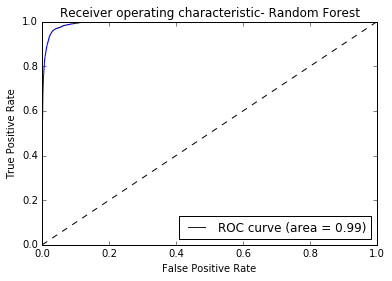

(best_fpr, best_tpr, best_threshold, best_fpr_by_cost, best_tpr_by_cost, best_threshold_by_cost) = 
(0.035810533047092676, 0.96452642781128062, 0.55582489747201624, 0.020828575343717171, 0.93118126995388439, 0.6127070994802426)
Area under the ROC curve : 0.945232


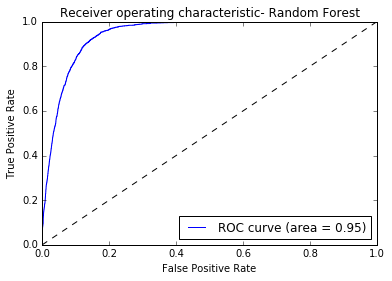

(test_fpr, test_tpr) = 
(0.06236779256226544, 0.6968698517298187)
fp = 914
tp = 1269
Using this best model to do predictions on test set, the profit of the bank is 9895 USD.

(test_fpr_by_cost, test_tpr_by_cost) = 
(0.043875810303650634, 0.5771554091158704)
fp = 643
tp = 1051
Using this best model to do predictions on test set, the profit of the bank is 9335 USD.



In [171]:
run_classifier(1)

Performing cross validation using parameter grid...
Best score for Cross Validation: 0.929291
Best param: {'criterion': 'entropy', 'max_depth': 5}
Area under the ROC curve : 0.936357


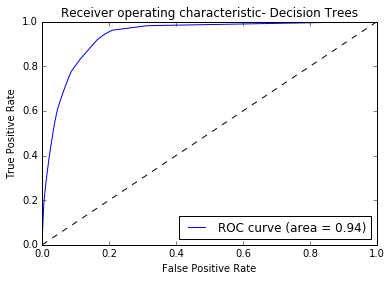

(best_fpr, best_tpr, best_threshold, best_fpr_by_cost, best_tpr_by_cost, best_threshold_by_cost) = 
(0.14899739642808205, 0.89286981199006743, 0.18133616118769882, 0.046498880920842277, 0.61120964881163531, 0.44800000000000001)
Area under the ROC curve : 0.930706


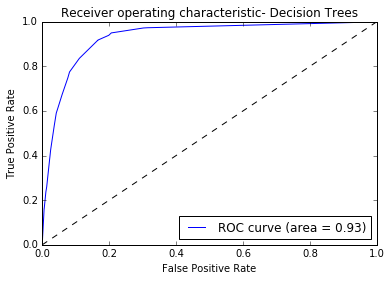

(test_fpr, test_tpr) = 
(0.1501194131695667, 0.8929159802306426)
fp = 2200
tp = 1626
Using this best model to do predictions on test set, the profit of the bank is 2390 USD.

(test_fpr_by_cost, test_tpr_by_cost) = 
(0.04605936540429888, 0.6090060406370126)
fp = 675
tp = 1109
Using this best model to do predictions on test set, the profit of the bank is 9885 USD.



In [172]:
run_classifier(4)

Performing cross validation using parameter grid...
Best score for Cross Validation: 0.935835
Best param: {'C': 0.1, 'class_weight': 'balanced'}
Area under the ROC curve : 0.937273


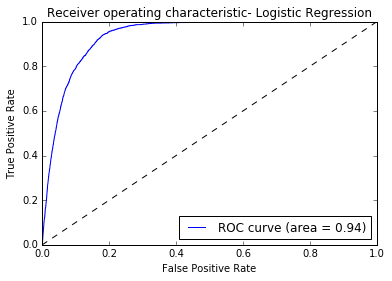

(best_fpr, best_tpr, best_threshold, best_fpr_by_cost, best_tpr_by_cost, best_threshold_by_cost) = 
(0.1642077376330334, 0.91734657680028375, 0.43246855338842316, 0.062028959027999819, 0.66264632848527849, 0.78666365635947044)
Area under the ROC curve : 0.938595


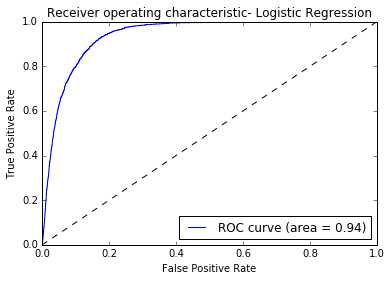

(test_fpr, test_tpr) = 
(0.1591265779597407, 0.9093904448105437)
fp = 2332
tp = 1656
Using this best model to do predictions on test set, the profit of the bank is 1520 USD.

(test_fpr_by_cost, test_tpr_by_cost) = 
(0.06141248720573183, 0.6781987918725975)
fp = 900
tp = 1235
Using this best model to do predictions on test set, the profit of the bank is 9525 USD.



In [173]:
run_classifier(3) # balanced class weight

Performing cross validation using parameter grid...
Best score for Cross Validation: 0.917436
Best param: {'probability': True, 'C': 0.1, 'gamma': 0.001, 'class_weight': 'balanced', 'kernel': 'linear'}
Area under the ROC curve : 0.921214


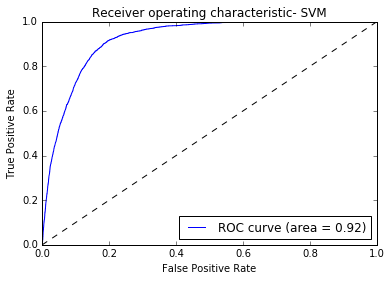

(best_fpr, best_tpr, best_threshold, best_fpr_by_cost, best_tpr_by_cost, best_threshold_by_cost) = 
(0.15799570639017038, 0.86732884001418942, 0.09232839759491937, 0.051203581053304706, 0.52926569705569348, 0.42059185040020119)
Area under the ROC curve : 0.924327


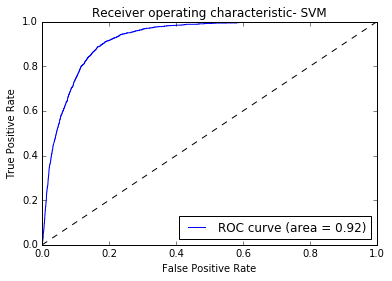

(test_fpr, test_tpr) = 
(0.15175707949505288, 0.8638110928061504)
fp = 2224
tp = 1573
Using this best model to do predictions on test set, the profit of the bank is 1355 USD.

(test_fpr_by_cost, test_tpr_by_cost) = 
(0.04756055953599454, 0.528281164195497)
fp = 697
tp = 962
Using this best model to do predictions on test set, the profit of the bank is 7460 USD.



In [174]:
run_classifier(2)

In [49]:
print(target)

[ 0.  0.  0. ...,  0.  1.  0.]


In [50]:
print(Y_test)

[ 1.  0.  0. ...,  0.  0.  0.]


In [85]:
x = np.linspace(1, 10, 10)
print(x)

[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.]


In [254]:
dates = pd.date_range('20130101', periods=6)
df = pd.DataFrame(np.random.randn(6,4), index=dates, columns=list('ABCD'))
print(df)
df = df.drop('A', 1)
df

                   A         B         C         D
2013-01-01  0.136983  0.776755 -0.750299  1.817715
2013-01-02  0.369684  2.260054 -1.301652  1.107262
2013-01-03 -2.773813  0.134416 -0.361066  2.127939
2013-01-04 -3.268119  1.093008  0.282197 -0.417872
2013-01-05 -1.177013  1.173055 -0.649322 -1.211887
2013-01-06 -0.614124  0.621220 -0.789541 -0.704394


,B,C,D
2013-01-01,0.776755,-0.750299,1.817715
2013-01-02,2.260054,-1.301652,1.107262
2013-01-03,0.134416,-0.361066,2.127939
2013-01-04,1.093008,0.282197,-0.417872
2013-01-05,1.173055,-0.649322,-1.211887
2013-01-06,0.621220,-0.789541,-0.704394
